# CEIA: Aprendizaje de Máquina I
## Trabajo Práctico Individual

Alumno: Alan Churichi

In [1]:
%load_ext lab_black

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import (    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

plt.style.use("seaborn")

RANDOM_STATE = 23

### Consigna

Una plataforma de ventas online nos contrata para que realicemos un modelo que nos permita detectar un posible fraude dada cierta operación para ello contamos con un dataset que contiene las siguientes columnas: 

- Step: representa una unidad de tiempo donde 1 step equivale a 1 hora 
- type: tipo de transacción en línea
- amount: el importe de la transacción 
- nameOrig: cliente que inicia la transacción 
- oldbalanceOrg: saldo antes de la transacción 
- newbalanceOrig: saldo después de la transacción 
- nameDest: destinatario de la transacción 
- oldbalanceDest: saldo inicial del destinatario antes de la transacción 
- newbalanceDest: el nuevo saldo del destinatario después de la transacción 
- isFraud: transacción fraudulenta 
  
Utilizando los modelos de clasificación vistos hasta el momento generar un notebook que permita de ser posible resolver el problema que nos está planteando el cliente.

[Link al dataset](https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset)


### Resolución

Lo primero será importar el dataset, analaizarlo y aplicar algunas técnicas de preprocesamiento. Tener datos preprocesados nos permitirá aplicar modelos de clasificación que incluyan más eficientes y que hagan uso de todas las columnas importantes en el dataset.

Importamos el dataset en un dataframe de pandas

In [2]:
df = pd.read_csv(
    "/tf/notebooks/CEIA-machine_learning/tp-individual/fraud-detection.csv"
)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
print(f"Cantidad de datos en el dataset: {df.shape[0]}")
print(f"Cantidad de 'nameOrig' distintos: {df['nameOrig'].unique().shape[0]}")
print(f"Cantidad de 'nameDest' distintos: {df['nameDest'].unique().shape[0]}")
print(f"Cantidad de 'type' distintos: {df['type'].unique().shape[0]}")

Cantidad de datos en el dataset: 6362620
Cantidad de 'nameOrig' distintos: 6353307
Cantidad de 'nameDest' distintos: 2722362
Cantidad de 'type' distintos: 5


*'nameOrig'* y *'nameDest'* son los nombres de las cuentas afectadas, estos datos son unicos por cuenta, por lo tanto no son relevantes para el problema a resolver.

In [4]:
df.drop(columns=["nameOrig", "nameDest"], inplace=True)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


Para evaluar si existe relación lineal entre variables, se grafica la matriz de correlación.

<AxesSubplot:>

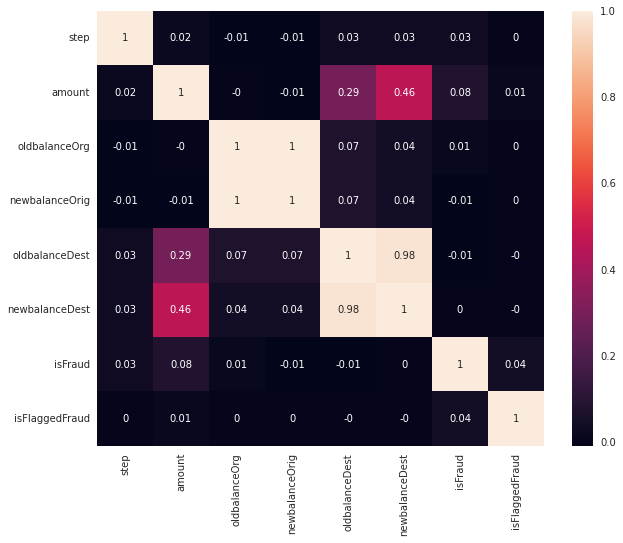

In [5]:
# Matriz de correlación, redondeo a 2 decimales
correlation_matrix = df.corr().round(2)
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(data=correlation_matrix, annot=True, ax=axes)

Como se ve hay correlación lineal entre *'oldbalanceOgs'* y *'newbalanceOrig'*, y entre *'oldbalanceDest'* y *'newbalanceDest'*. Esto el lógico ya que lo que se descuenta de una cuenta es lo que se le suma a otra. Eliminamos las columnas *'newbalanceOrig'* y *'newbalanceDest'*.

In [6]:
df.drop(columns=["newbalanceOrig", "newbalanceDest"], inplace=True)
df.head()

,step,type,amount,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,21182.0,1,0
4,1,PAYMENT,11668.14,41554.0,0.0,0,0


Vemos si existen valores faltantes.

In [7]:
df.isnull().sum(axis=0)

step              0
type              0
amount            0
oldbalanceOrg     0
oldbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

En el dataset no hay valores faltantes.

Creamos dummy variables para las feature categórica *'type'*.

In [8]:
type_dummies = pd.get_dummies(df["type"], prefix="type")
df.drop(columns=["type"], inplace=True)
type_dummies

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0
...,...,...,...,...,...
6362615,0,1,0,0,0
6362616,0,0,0,0,1
6362617,0,1,0,0,0
6362618,0,0,0,0,1


Normalizamos las variables numéricas utilizando el método *'z-score'*.

In [9]:
df_to_normalize = df.drop(columns=["isFraud", "isFlaggedFraud"])

scaler = StandardScaler().fit(df_to_normalize)
data_normalized = scaler.transform(df_to_normalize)
df_normalized = pd.DataFrame(data_normalized, columns=df_to_normalize.columns)

In [10]:
df = pd.concat([df_normalized, df[["isFraud", "isFlaggedFraud"]], type_dummies], axis=1)
df

,step,amount,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-1.703042,-0.281560,-0.229810,-0.323814,0,0,0,0,0,1,0
1,-1.703042,-0.294767,-0.281359,-0.323814,0,0,0,0,0,1,0
2,-1.703042,-0.297555,-0.288654,-0.323814,1,0,0,0,0,0,1
3,-1.703042,-0.297555,-0.288654,-0.317582,1,0,0,1,0,0,0
4,-1.703042,-0.278532,-0.274329,-0.323814,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,3.510123,0.264665,-0.171108,-0.323814,1,0,0,1,0,0,0
6362616,3.510123,10.153953,1.896491,-0.323814,1,0,0,0,0,0,1
6362617,3.510123,10.153953,1.896491,-0.303665,1,0,0,1,0,0,0
6362618,3.510123,1.109765,0.005581,-0.323814,1,0,0,0,0,0,1


Ahora nuestro dataset cuenta con 11 columnas.

Hacemos la división del dataset en *'train'* y *'test'* tomando una proporción 90-10.

In [11]:
df_x = df.drop(columns=["isFraud"])
df_y = df["isFraud"]

x_train, x_test, y_train, y_test = train_test_split(
    df_x, df_y, test_size=0.1, random_state=RANDOM_STATE, stratify=df_y
)

print(f"x train shape: {x_train.shape}")
print(f"x test shape: {x_test.shape}")
print(f"y train shape: {y_train.shape}")
print(f"y test shape: {y_test.shape}")

x train shape: (5726358, 10)
x test shape: (636262, 10)
y train shape: (5726358,)
y test shape: (636262,)


Revisamos el nivel de desbalanceo de las clases

In [12]:
df["isFraud"].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

Vemos que las clases se encuentran extremadamente desbalanceadas. Podríamos generar datos artificiales de la clase minoritaria para lograr el balanceo, pero esto introduciria muchos nuevos valores en un dataset que de por si ya es grande. Otra opción es eliminar filas de la clase mayoritaria y quedarnos con una igual cantidad de muestras de cada clase. Para hacer esto utilizamos la función *'RandomUnderSampler'*.

In [13]:
undersampler = RandomUnderSampler(sampling_strategy="majority")

x_train_us, y_train_us = undersampler.fit_resample(x_train, y_train)

print("Composición del training set:")
print(y_train_us.value_counts())

print("\nComposición del test set:")
print(y_test.value_counts())

Composición del training set:
0    7392
1    7392
Name: isFraud, dtype: int64

Composición del test set:
0    635441
1       821
Name: isFraud, dtype: int64


### Random Forest Classifier

Utilizamos un método de validación cruzada compuesta por divisiones de 5 folds y 10 iteraciones.

Ya que los datos de test aun presentan desbalance, es buena idea usar una métrica que considere el desbalanceo entre clases. En este caso utilizamos la métrica *'balanced_accuracy'*.

El modelo de Random Forest a utilizar estará compuesto por 100 árboles.

In [14]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
scores = cross_val_score(
    rf, x_train_us, y_train_us, scoring="balanced_accuracy", cv=cv, n_jobs=-1
)
print(f"Train balanced accuracy score: {scores.mean():.4f}")

Train balanced accuracy score: 0.9849


Entrenamos el modelo con el conjunto completo de datos de entrenamiento y luego analizamos la performance con los datos de test.

Test balanced accuracy score: 0.9845


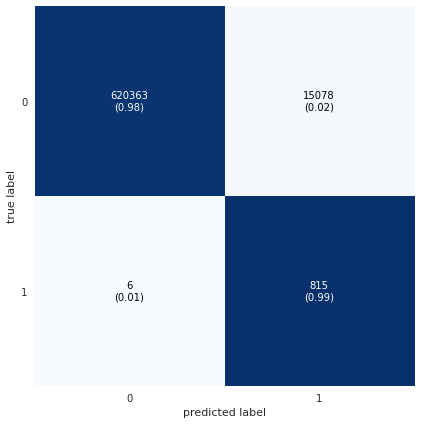

In [15]:
def plot_conf_matrix(x, y, figsize=(6, 6), show_normed=True):
    plot_confusion_matrix(
        conf_mat=confusion_matrix(x, y),
        figsize=figsize,
        show_normed=show_normed,
    )
    plt.tight_layout()


rf.fit(x_train_us, y_train_us)
y_pred = rf.predict(x_test)
test_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Test balanced accuracy score: {test_acc:.4f}")
plot_conf_matrix(y_test, y_pred)

Como se puede ver la performance es muy buena. De los 821 datos de test marcados como fraude solo 2 fueron clasificados erroneamente.

Realizamos pruebas con otros modelos para comparar la performance.

### Logistic Regression

Para evaluar un modelo de regresión logística utilizamos validación cruzada y la misma métrica *'balanced_accuracy'*.

In [16]:
logi = LogisticRegression(random_state=RANDOM_STATE)
scores = cross_val_score(
    logi, x_train_us, y_train_us, scoring="balanced_accuracy", cv=cv, n_jobs=-1
)
print(f"Train balanced accuracy score: {scores.mean():.4f}")

Train balanced accuracy score: 0.8528


Test balanced accuracy score: 0.8508


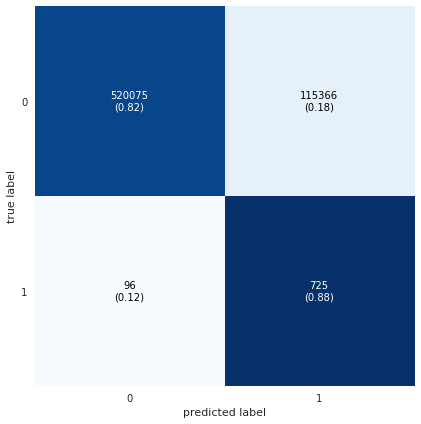

In [17]:
logi.fit(x_train_us, y_train_us)
y_pred = logi.predict(x_test)
test_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Test balanced accuracy score: {test_acc:.4f}")
plot_conf_matrix(y_test, y_pred)

Aunque el resultado es bueno, no es mejor que el obtenido con el modelo de Random Forest.

### SVM

Planteamos un modelo de Support Vector Machine (SVM). En concreto utilizaremos un modelo Support Vector Classification (SVC) que es parte de la familia de SVM. Nuevamente utilizaremos validación cruzada y *'balanced_accuracy'* como métrica.

La implementación de SVC en sklearn nos permite elegir entre distintos tipos de kernels. Evaluaremos todos ellos y nos quedaremos con el que obtenga mejor performance.

In [20]:
kernels = ["linear", "rbf", "sigmoid", "poly"]
best_kernel = {"name": "", "score": 0}

for kernel in kernels:
    svc = SVC(kernel=kernel, random_state=RANDOM_STATE)
    scores = cross_val_score(
        svc, x_train_us, y_train_us, scoring="balanced_accuracy", cv=cv, n_jobs=-1
    )
    score = scores.mean()
    if score > best_kernel["score"]:
        best_kernel["name"] = kernel
        best_kernel["score"] = score
    print(f"Train balanced accuracy score with kernel '{kernel}': {score:.4f}")

print(f"Best kernel '{best_kernel['name']}' with score: {best_kernel['score']:.4f}")

Train balanced accuracy score with kernel 'linear': 0.8759
Train balanced accuracy score with kernel 'rbf': 0.9023
Train balanced accuracy score with kernel 'sigmoid': 0.6936
Train balanced accuracy score with kernel 'poly': 0.8285
Best kernel 'rbf' with score: 0.9023


Test balanced accuracy score: 0.9093


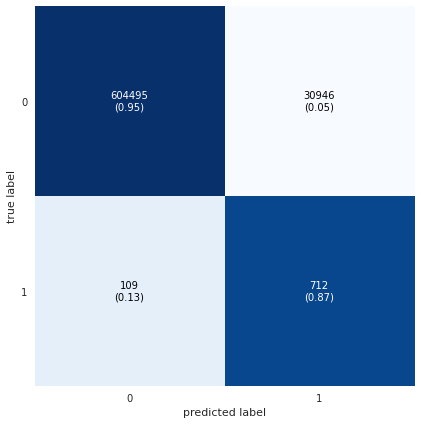

In [21]:
svc = SVC(kernel=best_kernel["name"], random_state=RANDOM_STATE)
svc.fit(x_train_us, y_train_us)
y_pred = svc.predict(x_test)
test_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Test balanced accuracy score: {test_acc:.4f}")
plot_conf_matrix(y_test, y_pred)

Si bien los resultados son mejores que los obtenidos con el modelo de Logistic Regression, no es mejor que el obtenido al utilizar Random Forest.

#### Conclusiones

En la siguente tabla se pueden observar la comparativa de los tres modelos.

| Model                 | Train accuracy   | Test accuracy |
|-----------------------|------------------|---------------|
| Random Forest         | 0.9849           | 0.9845        |
| Logistic Regression   | 0.8528           | 0.8508        |
| SVM ('rbf' kernel)    | 0.9023           | 0.9093        |

El modelo final a elegir para la resolución del problema es el modelo de Random Forest.

Sabiendo que el modelo de Random Forest es el que obtiene mejores resultados, el siguiente paso podría ser el tune de hiperparámetros del arbol, para intentar tener un mejor accuracy.

Para la búsqueda de hiperparámetros óptimos podría utilizarse alguna librería de automatización como PyCaert junto con MLflow para facilitar el reporte y la visualización.